In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install PyWavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 81.6 MB/s eta 0:00:00


In [3]:
import os

# Path where training data is stored
train_data_path = "/content/drive/MyDrive/Dataset/splitset/"

# Get participant IDs from existing training files
train_participants = [
    file.split("_")[0] for file in os.listdir(train_data_path) if file.endswith("_train.mat")
]
train_participants = sorted(set(map(int, train_participants)))  # Ensure unique and sorted IDs

print("Loaded train participants:", train_participants)

Loaded train participants: [1, 2, 3, 6, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 29, 30, 31, 32, 33, 35, 36, 37, 39, 42, 43, 45, 46, 47, 48]


In [4]:
import numpy as np
import scipy.io
import pywt
import matplotlib.pyplot as plt
import joblib
from mpl_toolkits.mplot3d import Axes3D  # For 3D visualization

sampling_rate = 256

# Define frequency bands
alpha_band = (8, 13)
theta_band = (4, 8)
low_beta_band = (13, 20)

# Specify the channels to use
selected_channels = [3, 5, 8, 14, 17, 19, 24, 25, 36, 39, 40, 45, 47, 52, 53]
selected_channels = [ch - 1 for ch in selected_channels]  # Convert to 0-based indexing

# Function to compute power using CWT
def compute_power_cwt(signal, scales, wavelet):
    coefficients, _ = pywt.cwt(signal, scales, wavelet, sampling_period=1.0/sampling_rate)
    return np.abs(coefficients) ** 2  # Power

# Initialize lists to store features for the entire training set
all_theta_beta_features = []
all_theta_alpha_features = []
all_theta_alpha_beta_features = []

# Loop through each participant
for participant in train_participants:
    # Load the .mat file for the participant
    train_file_path = f'/content/drive/MyDrive/Dataset/splitset/{int(participant)}_train.mat'
    data = scipy.io.loadmat(train_file_path)

    # Extract the EEG data (key is 'train_data' in the .mat file)
    participant_data = data['train_data']  # Shape: (timepoints, channels, trials)
    num_timepoints, num_channels, num_trials = participant_data.shape

    # Group trials into 20-second segments
    trial_duration = 1.5  # Duration of each trial in seconds
    segment_duration = 20  # Desired segment duration in seconds
    trials_per_segment = int(segment_duration / trial_duration)  # Number of trials per 20-second segment=13 trials

    # Extract 5-second windows from each 20-second segment
    window_duration = 5  # Duration of each window in seconds
    window_length = window_duration * sampling_rate  # Length of each window in samples
    overlap = 0.5  # 50% overlap between windows
    step_size = int(window_length * (1 - overlap))  # Step size for overlapping windows

    for start in range(0, num_trials - trials_per_segment + 1, trials_per_segment):
        # Extract 20-second segment for selected channels
        segment_data = participant_data[:, selected_channels, start:start + trials_per_segment]
        segment_signal = segment_data.reshape(-1, segment_data.shape[1])  # Flatten trials into a single time series

        # Ensure the segment is exactly 20 seconds
        segment_signal = segment_signal[:20 * sampling_rate, :]

        # Extract 5-second windows with overlap
        for i in range(0, len(segment_signal) - window_length + 1, step_size):
            window_signal = segment_signal[i:i + window_length, :]  # Shape: (window_length, selected_channels)

            # Compute all ratios for the window
            wavelet = 'cmor1.0-0.5'  # Complex Morlet wavelet

            # Compute scales using pywt.frequency2scale
            scales_alpha = pywt.frequency2scale(wavelet, np.array(alpha_band) / sampling_rate)
            scales_theta = pywt.frequency2scale(wavelet, np.array(theta_band) / sampling_rate)
            scales_low_beta = pywt.frequency2scale(wavelet, np.array(low_beta_band) / sampling_rate)

            window_theta_beta = []
            window_theta_alpha = []
            window_theta_alpha_beta = []

            for channel in range(len(selected_channels)):
                # Compute CWT for the channel
                alpha_power = compute_power_cwt(window_signal[:, channel], scales_alpha, wavelet).mean(axis=0)
                theta_power = compute_power_cwt(window_signal[:, channel], scales_theta, wavelet).mean(axis=0)
                low_beta_power = compute_power_cwt(window_signal[:, channel], scales_low_beta, wavelet).mean(axis=0)

                # Compute all ratios
                theta_beta_ratio = theta_power / low_beta_power
                theta_alpha_ratio = theta_power / alpha_power
                theta_alpha_beta_ratio = theta_power / (alpha_power + low_beta_power)

                window_theta_beta.append(theta_beta_ratio.mean())  # Average ratio over time
                window_theta_alpha.append(theta_alpha_ratio.mean())
                window_theta_alpha_beta.append(theta_alpha_beta_ratio.mean())

            # Aggregate features over channels
            all_theta_beta_features.append(np.mean(window_theta_beta))
            all_theta_alpha_features.append(np.mean(window_theta_alpha))
            all_theta_alpha_beta_features.append(np.mean(window_theta_alpha_beta))

# Convert features to numpy arrays and combine into feature matrix
features = np.column_stack((
    all_theta_beta_features,
    all_theta_alpha_features,
    all_theta_alpha_beta_features
))  # Shape: (num_windows, 3)

In [5]:
from sklearn.preprocessing import StandardScaler
import joblib

#Normalize the features
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

# Save the scaler for later use
scaler_path = "/content/drive/MyDrive/Dataset/clustering_models/DBSCAN_TLBR_TAR_TLBAR_Scaler.pkl"
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to {scaler_path}")

Scaler saved to /content/drive/MyDrive/Dataset/clustering_models/DBSCAN_TLBR_TAR_TLBAR_Scaler.pkl


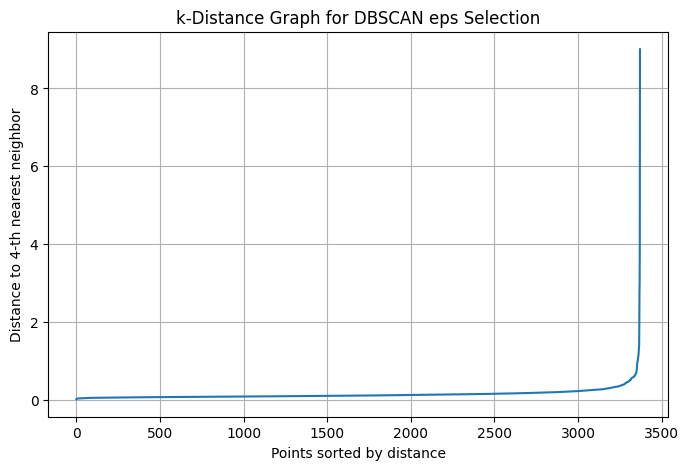

In [6]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

min_samples = 4
nbrs = NearestNeighbors(n_neighbors=min_samples).fit(normalized_features)
distances, _ = nbrs.kneighbors(normalized_features)

# Sort the distances and plot
k_distances = distances[:, -1]  # Distance to the k-th neighbor
k_distances_sorted = np.sort(k_distances)

plt.figure(figsize=(8, 5))
plt.plot(k_distances_sorted)
plt.xlabel('Points sorted by distance')
plt.ylabel(f'Distance to {min_samples}-th nearest neighbor')
plt.title('k-Distance Graph for DBSCAN eps Selection')
plt.grid(True)
plt.show()

The elbow appears around a 4th nearest neighbor distance of approximately 1.05.

In [7]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

eps = 1.05
min_samples = 4

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(normalized_features)

# Count the number of clusters (excluding noise)
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)

if n_clusters >= 2:
    sil_score = silhouette_score(normalized_features, labels)
    dbi_score = davies_bouldin_score(normalized_features, labels)
    print(f"Silhouette Score: {sil_score:.4f}")
    print(f"Davies-Bouldin Index: {dbi_score:.4f}")
else:
    sil_score = dbi_score = float('nan')  # Not valid for < 2 clusters
    print("Not enough clusters to compute Silhouette or DBI (need at least 2 clusters).")


Not enough clusters to compute Silhouette or DBI (need at least 2 clusters).


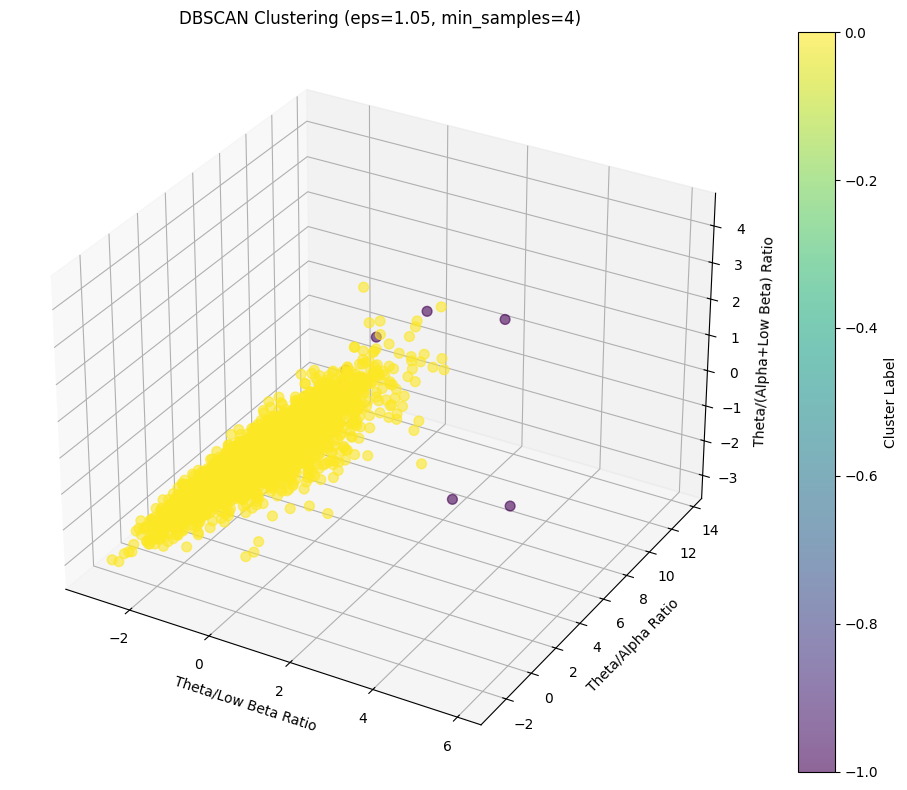

In [8]:
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import numpy as np

# Plot the clusters (for 3D visualization)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with colors based on cluster labels
scatter = ax.scatter(normalized_features[:, 0], normalized_features[:, 1], normalized_features[:, 2],
                     c=labels, cmap='viridis', s=50, alpha=0.6)

ax.set_xlabel('Theta/Low Beta Ratio')
ax.set_ylabel('Theta/Alpha Ratio')
ax.set_zlabel('Theta/(Alpha+Low Beta) Ratio')
ax.set_title(f'DBSCAN Clustering (eps={eps}, min_samples={min_samples})')

# Add a color bar which maps values to colors
plt.colorbar(scatter, ax=ax, label='Cluster Label')
plt.tight_layout()
plt.show()